# LinRegProject

## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', 300)

%matplotlib inline

In [2]:
# Global Burden of Disease Collaborative Network. #
# Global Burden of Disease Study 2017 (GBD 2017) Results. #
# Seattle, United States: Institute for Health Metrics and Evaluation (IHME), 2018. #
# Available from http://ghdx.healthdata.org/gbd-results-tool. #
# Renamed to 'suicide_rates.csv' #
df1 = pd.read_csv('IHME-GBD_2017_DATA-f57da2bf-1.csv') # 2005-2016, from Global Health Data Exchange from WHO

# Kaggle World Happiness dataset by user: Alcides Oxa #
df2 = pd.read_csv('world-happiness-report-2005-2018.csv', delimiter=';') # 2005-2018, from UN WHO

# Capitals from https://www.jasom.net/list-of-capital-cities-with-latitude-and-longitude/ #
df3 = pd.read_csv('capitals.csv')

df4 = pd.read_csv('mental_disorder_substance_use.csv') # from WHO 1990-2016

### 2005-2016 merge ###
### Target Variable: Suicide Rates ###

## Cleaning Data/Merging Data

In [3]:
df3

,Country,Capital,Latitude,Longitude
0,Abkhazia,Sukhumi,43.001525,41.023415
1,Afghanistan,Kabul,34.575503,69.240073
2,Aland Islands,Mariehamn,60.100000,19.933333
3,Albania,Tirana,41.327546,19.818698
4,Algeria,Algiers,36.752887,3.042048
...,...,...,...,...
247,Wallis and Futuna,Mata-Utu,-13.282509,-176.176447
248,Western Sahara,El Aaiún,27.125287,-13.162500
249,Yemen,Sana'a,15.369445,44.191007
250,Zambia,Lusaka,-15.387526,28.322817


In [4]:
### Use columns of countries, year, suicide rate ###
df1 = df1[['location_name', 'year', 'val']]
df1 = df1.rename({'location_name': 'country', 'val': 'suicide_rate'}, axis=1)
### Suicides/100,000 ###

### Order DataFrame entries by country then year ###
df1 = pd.DataFrame(df1.groupby(['country', 'year'])['suicide_rate'].sum()).reset_index()

### Round suicide_rate to 2 significant digits ###
df1['suicide_rate'] = round(df1['suicide_rate'], 2)

In [5]:
### Match column names for join ###
df2.rename({'Country name': 'country', 'Year': 'year'}, axis=1, inplace=True)
df4.rename({'Entity':'country', 'Year':'year'}, axis=1, inplace=True)

In [6]:
### Index for join ###
df1 = df1.groupby(['country', 'year']).sum()
df2 = df2.groupby(['country', 'year']).sum()
df4 = df4.groupby(['country', 'year']).sum()

In [7]:
### Join df1 and df2 ###
data = df1.join(df2)

data.reset_index(inplace=True)

In [8]:
#data

In [9]:
### Drop Nan values (may add means later) ###
data.dropna(inplace=True)

### Keep relevant columns ###
data = data.iloc[:, 0:10]

In [10]:
### Add mean log gdp for Syria to 2015 ###
data.loc[(data['country'] == 'Syria') & (data['year'] == 2015)] # Index: 2014
data.at[2014, 'Log GDP per capita'] = np.nan
data.groupby('country').mean().loc['Syria'] # Mean = 8.530000
data.at[2014, 'Log GDP per capita'] = 8.530000

In [11]:
### Drop Somalia, has no gdp values ###
data.loc[data['country'] == 'Somalia'] # Indices: 1881, 1882, 1883
data.drop([1881, 1882, 1883], inplace=True)

In [12]:
### Add GDP/capita column from log(gdp/capita) ###
data['gdp_cap'] = np.exp(data['Log GDP per capita'])

### Round to 2 significant digits ###
data = round(data, 2)

In [13]:
### Drop irrelevant columns ###
df3.drop(columns=['Capital'], inplace=True)

In [14]:
#df3

In [15]:
### Rename column for merge ###
df3.rename({'Country': 'country'}, axis=1, inplace=True)

In [16]:
### Merge df3 onto data ###
data = data.merge(df3, on='country')

In [17]:
data = data.groupby(['country', 'year']).sum()
data = data.join(df4)
data.dropna(inplace=True)
data.reset_index(inplace=True)

## EDA/Feature Engineering

In [ ]:
ols

In [18]:
### Rename column for merge ###
data.rename({'Life Ladder': 'Life_Ladder', 'Log GDP per capita':'log_gdp', 'Social support': 'social_support', 'Healthy life expectancy at birth': 'life_expectancy', 'Freedom to make life choices': 'Choice_freedom', 'Perceptions of corruption':'Perception_of_corrupt','Schizophrenia (%)':'Schizophrenia', 'Bipolar disorder (%)':'Bipolar', 'Eating disorders (%)': 'Eating_disorder', 'Anxiety disorders (%)': 'Anxiety', 'Drug use disorders (%)': 'Drug_abuse', 'Depression (%)':'Depression', 'Alcohol use disorders (%)':'Alcohol_abuse'}, axis=1, inplace=True)



In [19]:
data.columns

Index(['country', 'year', 'suicide_rate', 'Life_Ladder', 'log_gdp',
       'social_support', 'life_expectancy', 'Choice_freedom', 'Generosity',
       'Perception_of_corrupt', 'gdp_cap', 'Latitude', 'Longitude',
       'Schizophrenia', 'Bipolar', 'Eating_disorder', 'Anxiety', 'Drug_abuse',
       'Depression', 'Alcohol_abuse'],
      dtype='object')

Text(0.5, 1.0, 'Suicide Rates and GDP')

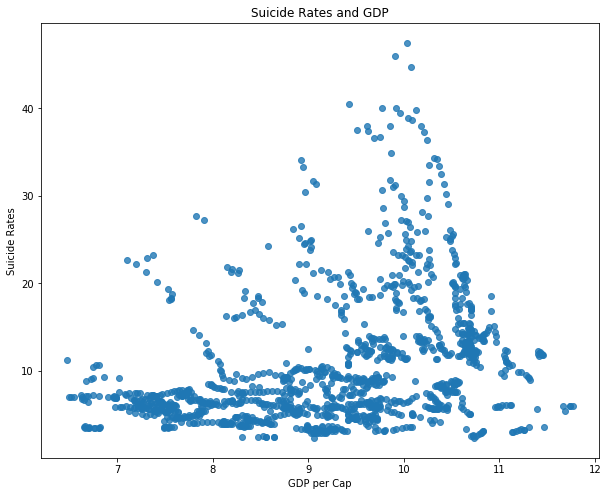

In [68]:
plt.figure(figsize=(10,8))
sns.regplot(x='log_gdp', y='suicide_rate', data=data, fit_reg=False)
plt.xlabel('GDP per Cap')
plt.ylabel('Suicide Rates')
plt.title('Suicide Rates and GDP')

Text(0.5, 1.0, 'Suicide Rates and Happiness')

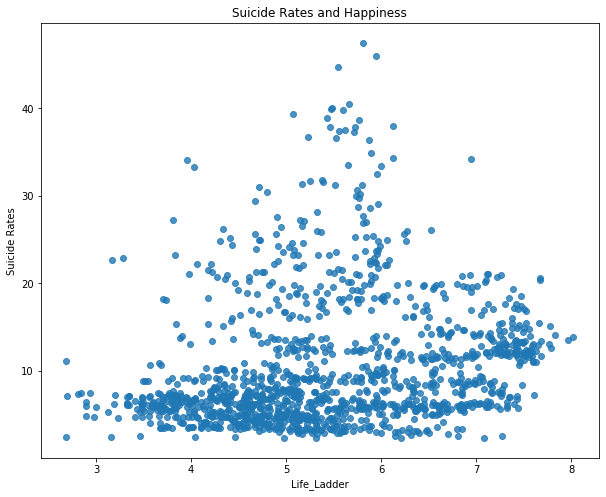

In [63]:
plt.figure(figsize=(10,8))
sns.regplot(x='Life_Ladder', y='suicide_rate', data=data, fit_reg=False)
plt.ylabel('Suicide Rates')
plt.xlabel('Life_Ladder')
plt.title('Suicide Rates and Happiness')

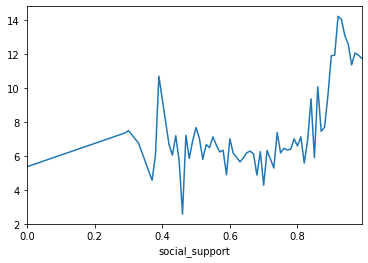

In [50]:
data.groupby('social_support')['suicide_rate'].median().plot()

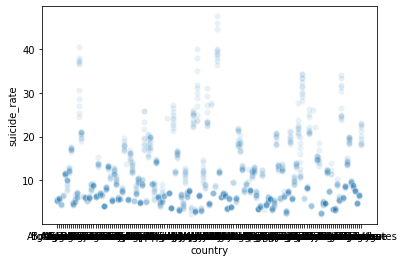

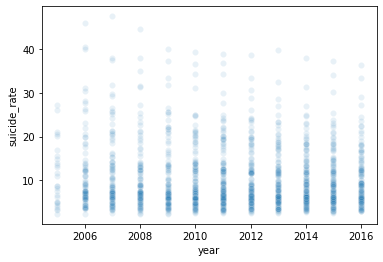

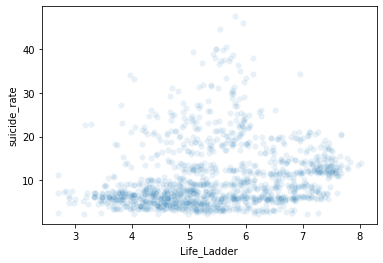

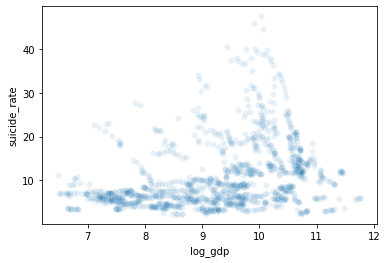

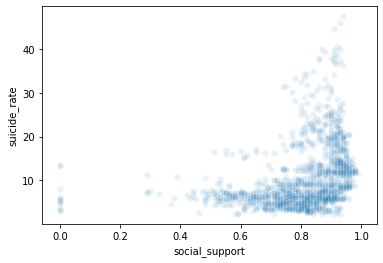

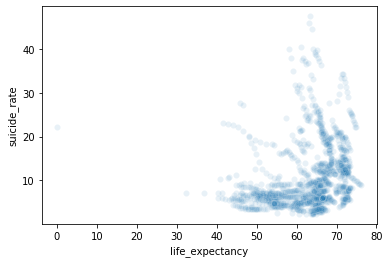

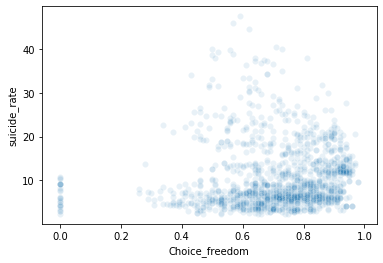

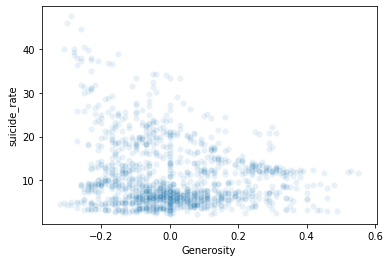

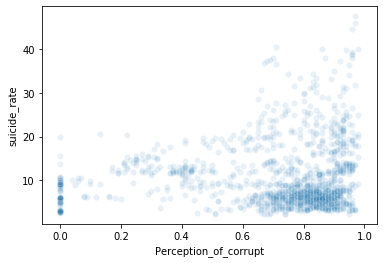

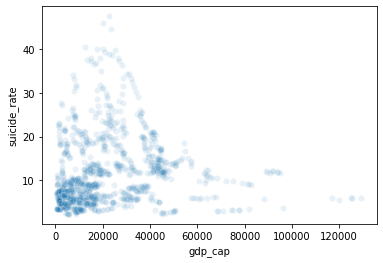

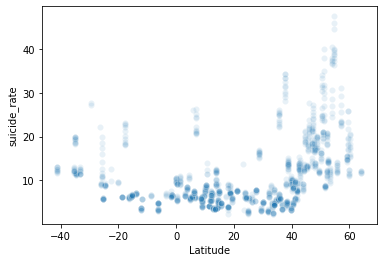

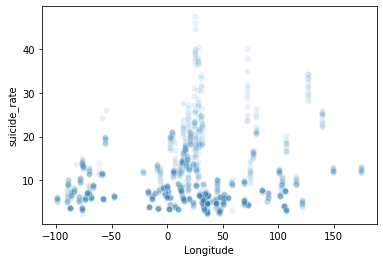

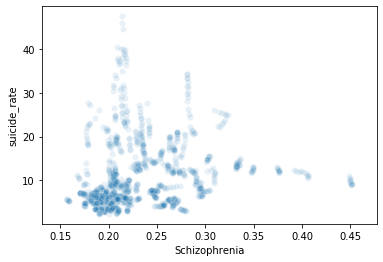

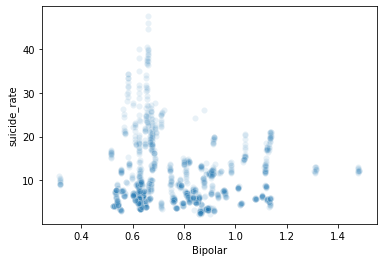

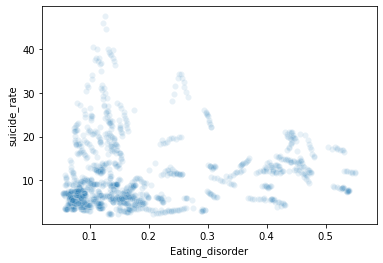

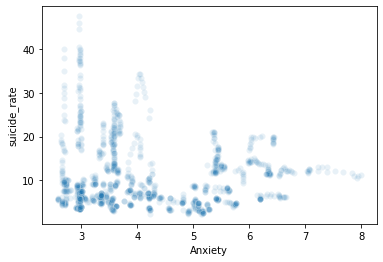

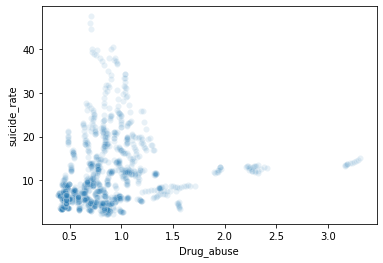

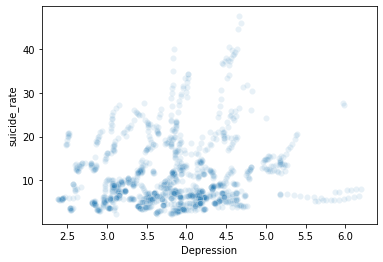

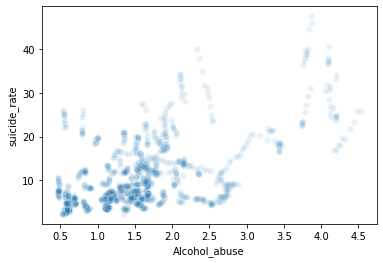

In [20]:
### EDA for Suicide Rate vs. Features ###
for feat in data.keys():
    if feat == 'suicide_rate':
        continue
    else:
        sns.scatterplot(data[feat], data['suicide_rate'], alpha=.1)
        plt.show()

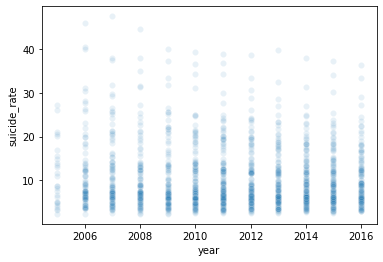

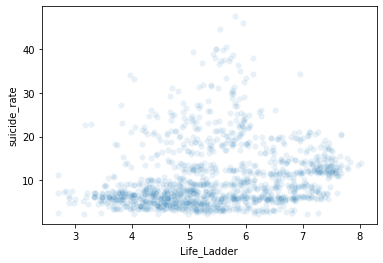

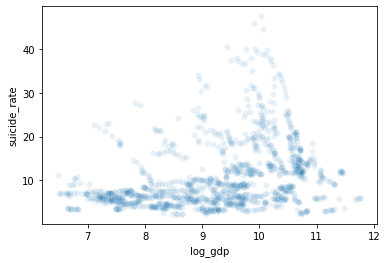

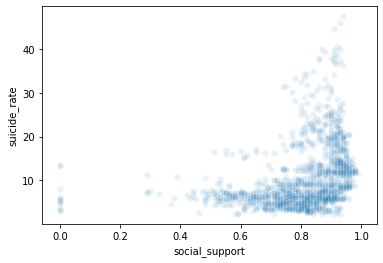

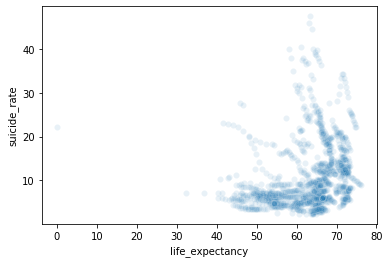

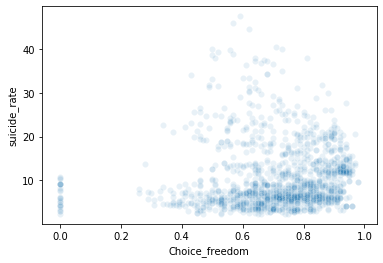

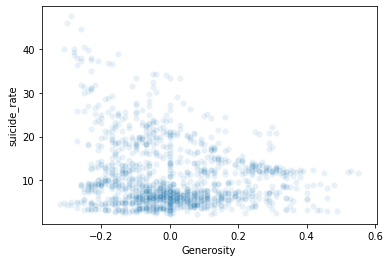

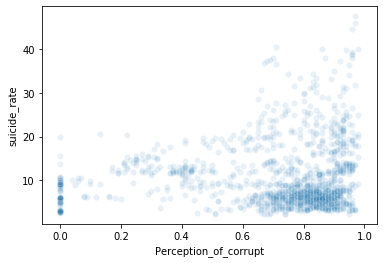

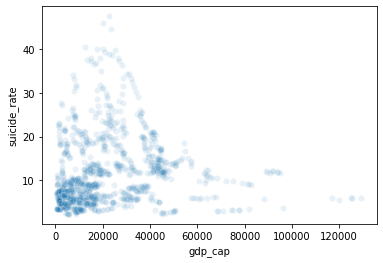

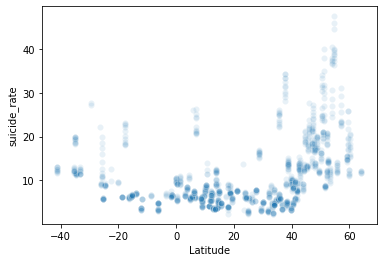

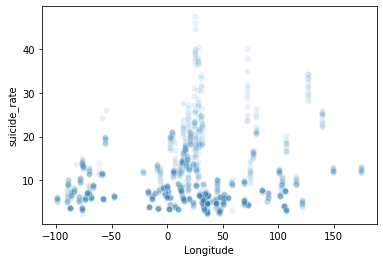

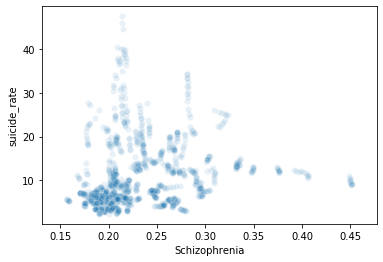

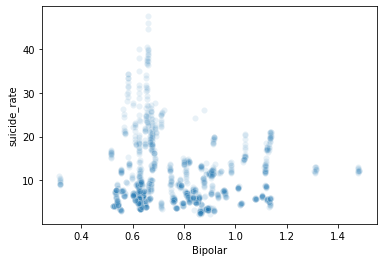

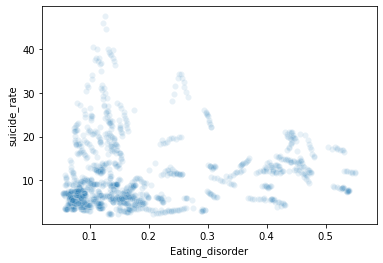

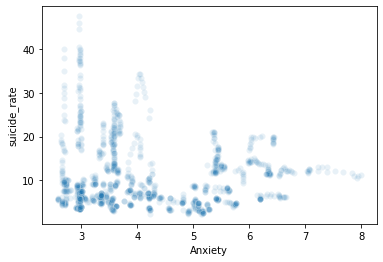

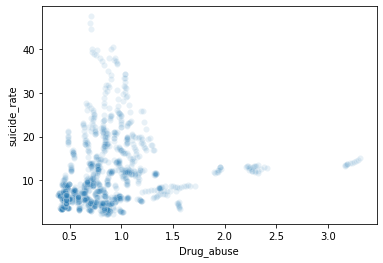

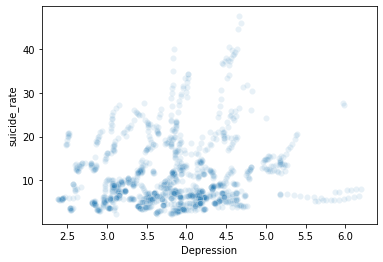

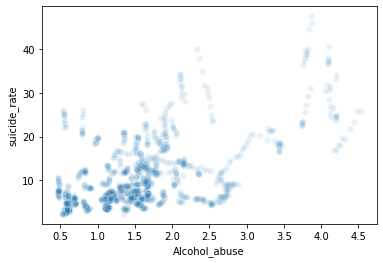

In [21]:
### EDA for Suicide Rate vs. transforming of Features ###
for feat in data.keys():
    if (feat == 'suicide_rate' or feat == 'country'):
        continue
    else:
        sns.scatterplot(data[feat], data['suicide_rate'], alpha=0.1)
        plt.show()

In [22]:
### Adding log tranformation of target variable ###
data['log_s_rate'] = np.log(data['suicide_rate'].values)

In [ ]:
sns.scatterplot(data.groupby('year').mean().index, data.groupby('year')['suicide_rate'].mean())

In [57]:
data

,Life_Ladder,log_gdp,social_support,life_expectancy,Choice_freedom,Generosity,Perception_of_corrupt,gdp_cap,Latitude,Longitude,Schizophrenia,Bipolar,Eating_disorder,Anxiety,Drug_abuse,Depression,Alcohol_abuse,log_gdp_and_Alcohol_abuse,social_support_and_Alcohol_abuse,life_expectancy_and_Alcohol_abuse,Perception_of_corrupt_and_Alcohol_abuse,Latitude_and_Alcohol_abuse,Longitude_and_Alcohol_abuse,Depression_and_Alcohol_abuse
0,3.72,7.17,0.45,50.80,0.72,0.18,0.88,1298.14,34.575503,69.240073,0.156408,0.759600,0.077913,5.021338,1.154592,4.418744,0.603914,4.330061,0.271761,30.678811,0.531444,20.880617,41.815022,2.668539
1,4.40,7.33,0.55,51.20,0.68,0.20,0.85,1531.17,34.575503,69.240073,0.156833,0.759858,0.079470,5.024297,1.168156,4.414171,0.605023,4.434822,0.332763,30.977198,0.514270,20.918988,41.891864,2.670677
2,4.76,7.39,0.54,51.60,0.60,0.13,0.71,1614.25,34.575503,69.240073,0.157271,0.760281,0.080897,5.026857,1.181743,4.417986,0.606372,4.481089,0.327441,31.288797,0.430524,20.965618,41.985244,2.678943
3,3.83,7.42,0.52,51.92,0.50,0.17,0.73,1660.74,34.575503,69.240073,0.157635,0.760101,0.081886,5.026279,1.183578,4.413557,0.607311,4.506247,0.315802,31.531582,0.443337,20.998080,42.050252,2.680401
4,3.78,7.52,0.52,52.24,0.53,0.24,0.78,1839.27,34.575503,69.240073,0.158005,0.760086,0.082902,5.025219,1.183110,4.409314,0.608443,4.575491,0.316390,31.785059,0.474585,21.037221,42.128633,2.682816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,4.96,7.53,0.90,49.54,0.47,-0.08,0.86,1871.37,-17.825166,31.033510,0.177150,0.610035,0.075505,3.384810,0.642642,3.543590,1.657876,12.483808,1.492089,82.131191,1.425774,-29.551920,51.449720,5.874834
1323,4.69,7.57,0.80,50.96,0.58,-0.08,0.83,1929.77,-17.825166,31.033510,0.177535,0.610568,0.075941,3.386123,0.646264,3.559066,1.660033,12.566453,1.328027,84.595306,1.377828,-29.590372,51.516666,5.908169
1324,4.18,7.56,0.77,52.38,0.64,-0.05,0.82,1925.14,-17.825166,31.033510,0.177906,0.611041,0.076707,3.387128,0.649074,3.572592,1.662183,12.566103,1.279881,87.065141,1.362990,-29.628687,51.583370,5.938302
1325,3.70,7.56,0.74,53.80,0.67,-0.10,0.81,1912.28,-17.825166,31.033510,0.178264,0.611463,0.076897,3.387882,0.650676,3.581816,1.664371,12.582645,1.231635,89.543163,1.348141,-29.667690,51.651276,5.961472


In [ ]:
### Create DataFrame of means values of target variable and features by country ###
data2 = data.copy()
data2 = data2.groupby('country').mean()

In [ ]:
data2

In [ ]:
### Looking at means by country ###
for feat in data2.keys():
    if (feat == 'suicide_rate') or (feat == 'log_s_rate') or (feat == 'country'):
        continue
    else:
        sns.scatterplot(data2[feat], data2['suicide_rate'], alpha=0.5)
        plt.show()

In [23]:
data.corr()

,year,suicide_rate,Life_Ladder,log_gdp,social_support,life_expectancy,Choice_freedom,Generosity,Perception_of_corrupt,gdp_cap,Latitude,Longitude,Schizophrenia,Bipolar,Eating_disorder,Anxiety,Drug_abuse,Depression,Alcohol_abuse,log_s_rate
year,1.000000,-0.068554,-0.023667,0.057537,-0.035390,0.115193,0.077090,-0.013246,-0.066642,0.051464,0.025692,0.007692,-0.000252,0.008686,0.040300,0.007015,0.001609,-0.011612,-0.002714,-0.043582
suicide_rate,-0.068554,1.000000,0.205590,0.327994,0.317670,0.240884,0.070950,-0.190471,0.099392,0.208544,0.338519,0.141087,0.213130,-0.050135,0.146218,-0.049730,0.216666,0.126660,0.575983,0.938141
Life_Ladder,-0.023667,0.205590,1.000000,0.787890,0.552553,0.727703,0.436594,0.236668,-0.360779,0.701791,0.239917,-0.178716,0.528440,0.610503,0.728725,0.508795,0.525412,-0.019817,0.072724,0.273503
log_gdp,0.057537,0.327994,0.787890,1.000000,0.501190,0.814974,0.280928,0.026186,-0.329910,0.847378,0.401797,-0.001972,0.557318,0.569619,0.764654,0.540005,0.575496,-0.029502,0.035446,0.355340
social_support,-0.035390,0.317670,0.552553,0.501190,1.000000,0.466146,0.379122,0.088345,-0.094483,0.345893,0.145940,-0.099165,0.322727,0.338159,0.431617,0.221827,0.272837,-0.081580,0.217021,0.349200
life_expectancy,0.115193,0.240884,0.727703,0.814974,0.466146,1.000000,0.296739,0.057264,-0.269007,0.631627,0.408657,-0.024445,0.598804,0.546634,0.687452,0.467002,0.487432,-0.171979,0.062061,0.292700
Choice_freedom,0.077090,0.070950,0.436594,0.280928,0.379122,0.296739,1.000000,0.317173,-0.163954,0.300070,-0.046105,-0.078828,0.279313,0.285957,0.354261,0.237371,0.230340,0.059165,-0.014290,0.152526
Generosity,-0.013246,-0.190471,0.236668,0.026186,0.088345,0.057264,0.317173,1.000000,-0.175103,0.160467,-0.094601,0.117774,0.310712,0.165296,0.213348,0.272929,0.234373,0.096879,-0.196888,-0.108785
Perception_of_corrupt,-0.066642,0.099392,-0.360779,-0.329910,-0.094483,-0.269007,-0.163954,-0.175103,1.000000,-0.486139,-0.094158,-0.162755,-0.337598,-0.270155,-0.348008,-0.302232,-0.287117,-0.127977,0.154241,0.064380
gdp_cap,0.051464,0.208544,0.701791,0.847378,0.345893,0.631627,0.300070,0.160467,-0.486139,1.000000,0.344680,0.060040,0.497334,0.531651,0.775208,0.523604,0.535286,0.107243,-0.081199,0.249479


In [ ]:
#pd.plotting.scatter_matrix(data.drop(columns=['year', 'country', 'suicide_rate', 'log_s_rate']), figsize=[9, 9])
#plt.show()

In [ ]:
#data[data['suicide_rate'] > 30]

In [ ]:
data

## Feature and Model Selection

### Selecting Features

In [24]:
### Import modules ###
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, Ridge
from itertools import combinations
from sklearn.metrics import r2_score

In [27]:
#Setting our target variable and features
features = data
target = data.log_s_rate

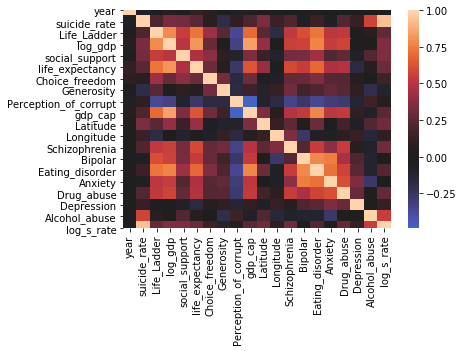

In [28]:
### Heatmap of correlation between features ###
sns.heatmap(features.corr(), center=0)
plt.show()

In [29]:
features.drop(['country', 'year', 'suicide_rate', 'log_s_rate'], axis=1, inplace=True)

In [30]:
#combinations(features, features) using itertools to make a combination of every column
interactions = list(combinations(features.columns, 2))

In [ ]:
interactions

In [31]:
### Create train-test split ###
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=34, test_size=0.2)
### Log Suicide Rates is our target###

In [32]:
### Scale the data by training set and testing set ###
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=features.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=features.columns)

In [33]:
int_feat = []
for i in interactions:
    X_int = pd.DataFrame(X_train[i[0]] * X_train[i[1]])
    model = LinearRegression()
    model.fit(X_int, y_train)
    y_train_pred = model.predict(X_int)
    train_r_sq = metrics.r2_score(np.exp(y_train), np.exp(y_train_pred))
    if train_r_sq > 0.3:
        int_feat.append(i)
        print(i, '{}'.format(train_r_sq))

('log_gdp', 'Alcohol_abuse') 0.40066878961586494
('social_support', 'Alcohol_abuse') 0.3766704347791189
('life_expectancy', 'Alcohol_abuse') 0.3468494293232286
('Perception_of_corrupt', 'Alcohol_abuse') 0.3217666887477538
('Latitude', 'Alcohol_abuse') 0.39233337077143215
('Longitude', 'Alcohol_abuse') 0.32889198547213905
('Depression', 'Alcohol_abuse') 0.32341455822264


In [34]:
for feat in int_feat:
    features['{}_and_{}'.format(feat[0], feat[1])] = features[feat[0]] * features[feat[1]]

In [35]:
features

,Life_Ladder,log_gdp,social_support,life_expectancy,Choice_freedom,Generosity,Perception_of_corrupt,gdp_cap,Latitude,Longitude,Schizophrenia,Bipolar,Eating_disorder,Anxiety,Drug_abuse,Depression,Alcohol_abuse,log_gdp_and_Alcohol_abuse,social_support_and_Alcohol_abuse,life_expectancy_and_Alcohol_abuse,Perception_of_corrupt_and_Alcohol_abuse,Latitude_and_Alcohol_abuse,Longitude_and_Alcohol_abuse,Depression_and_Alcohol_abuse
0,3.72,7.17,0.45,50.80,0.72,0.18,0.88,1298.14,34.575503,69.240073,0.156408,0.759600,0.077913,5.021338,1.154592,4.418744,0.603914,4.330061,0.271761,30.678811,0.531444,20.880617,41.815022,2.668539
1,4.40,7.33,0.55,51.20,0.68,0.20,0.85,1531.17,34.575503,69.240073,0.156833,0.759858,0.079470,5.024297,1.168156,4.414171,0.605023,4.434822,0.332763,30.977198,0.514270,20.918988,41.891864,2.670677
2,4.76,7.39,0.54,51.60,0.60,0.13,0.71,1614.25,34.575503,69.240073,0.157271,0.760281,0.080897,5.026857,1.181743,4.417986,0.606372,4.481089,0.327441,31.288797,0.430524,20.965618,41.985244,2.678943
3,3.83,7.42,0.52,51.92,0.50,0.17,0.73,1660.74,34.575503,69.240073,0.157635,0.760101,0.081886,5.026279,1.183578,4.413557,0.607311,4.506247,0.315802,31.531582,0.443337,20.998080,42.050252,2.680401
4,3.78,7.52,0.52,52.24,0.53,0.24,0.78,1839.27,34.575503,69.240073,0.158005,0.760086,0.082902,5.025219,1.183110,4.409314,0.608443,4.575491,0.316390,31.785059,0.474585,21.037221,42.128633,2.682816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,4.96,7.53,0.90,49.54,0.47,-0.08,0.86,1871.37,-17.825166,31.033510,0.177150,0.610035,0.075505,3.384810,0.642642,3.543590,1.657876,12.483808,1.492089,82.131191,1.425774,-29.551920,51.449720,5.874834
1323,4.69,7.57,0.80,50.96,0.58,-0.08,0.83,1929.77,-17.825166,31.033510,0.177535,0.610568,0.075941,3.386123,0.646264,3.559066,1.660033,12.566453,1.328027,84.595306,1.377828,-29.590372,51.516666,5.908169
1324,4.18,7.56,0.77,52.38,0.64,-0.05,0.82,1925.14,-17.825166,31.033510,0.177906,0.611041,0.076707,3.387128,0.649074,3.572592,1.662183,12.566103,1.279881,87.065141,1.362990,-29.628687,51.583370,5.938302
1325,3.70,7.56,0.74,53.80,0.67,-0.10,0.81,1912.28,-17.825166,31.033510,0.178264,0.611463,0.076897,3.387882,0.650676,3.581816,1.664371,12.582645,1.231635,89.543163,1.348141,-29.667690,51.651276,5.961472


### Wrapper Method

In [36]:
### Instantiate linear regression object ###
ols = LinearRegression() # Must have a fit() method

In [66]:
# building a linear regression model using statsmodel 
lr_model = ols(formula='suicide_rate~gdp_cap', data=data).fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           suicide_rate   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     60.24
Date:                Wed, 26 Feb 2020   Prob (F-statistic):           1.66e-14
Time:                        09:52:05   Log-Likelihood:                -4486.1
No. Observations:                1327   AIC:                             8976.
Df Residuals:                    1325   BIC:                             8987.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.9883      0.272     33.025      0.000       8.454       9.522
gdp_cap     8.149e-05   1.05e-05      7.762      0.000    6.09e-05       0.000
==============================================================================
Omnibus:                      469.294   Durbin-Watson:                   0.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1512.948
Skew:                           1.772   Prob(JB):                         0.00
Kurtosis:                       6.847   Cond. No.                     3.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
# building a linear regression model using statsmodel 
lr_model = ols(formula='suicide_rate~Life_Ladder', data=data).fit()

lr_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           suicide_rate   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     58.48
Date:                Wed, 26 Feb 2020   Prob (F-statistic):           3.94e-14
Time:                        09:52:33   Log-Likelihood:                -4487.0
No. Observations:                1327   AIC:                             8978.
Df Residuals:                    1325   BIC:                             8988.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.3075      0.955      3.462      0.001       1.433       5.182
Life_Ladder     1.3110      0.171      7.647      0.000       0.975       1.647
==============================================================================
Omnibus:                      488.319   Durbin-Watson:                   0.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1594.788
Skew:                           1.848   Prob(JB):                         0.00
Kurtosis:                       6.896   Cond. No.                         28.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.support_]
removed_columns = X_train.columns[~selector.support_]

In [38]:
### Removed feature ###
print(removed_columns)

Index(['Life_Ladder', 'life_expectancy', 'Latitude', 'Anxiety'], dtype='object')


In [39]:
### Check RMSE of prelim model ###
ols.fit(X_train, y_train)
y_train_pred = ols.predict(X_train)
y_pred = ols.predict(X_test)

train_rmse = metrics.mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred)))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 3.3322164791211115
Testing Error: 4.955595020354289


In [40]:
### Check RMSE of prelim - Life ladder model ###
X_train_minus = X_train.drop(['Life_Ladder', 'life_expectancy', 'Latitude', 'Anxiety'], axis=1)
X_test_minus = X_test.drop(['Life_Ladder', 'life_expectancy', 'Latitude', 'Anxiety'], axis=1)

ols.fit(X_train_minus, y_train)
y_train_pred = ols.predict(X_train_minus)
y_pred = ols.predict(X_test_minus)

train_rmse = metrics.mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred)))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 3.3310448621584867
Testing Error: 4.91957527993651


In [41]:
### Check RMSE of Lasso and Ridge ###
lasso = Lasso(alpha=0.01, normalize=False)
ridge = Ridge(alpha=1, normalize=False)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)
y_r_train_pred = ridge.predict(X_train)
y_r_pred = ridge.predict(X_test)

train_rmse = metrics.mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred)))
print('Lasso Training Error: '+ str(train_rmse) )
print('Lasso Testing Error: '+ str(test_rmse) )

r_train_rmse = metrics.mean_absolute_error(np.exp(y_train), np.exp(y_r_train_pred))
r_test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_r_pred)))
print('Ridge Training Error: '+ str(r_train_rmse) )
print('Ridge Testing Error: '+ str(r_test_rmse) )

Lasso Training Error: 3.5333578525816343
Lasso Testing Error: 5.353489895478521
Ridge Training Error: 3.3207657991489006
Ridge Testing Error: 4.939100010356532


In [42]:
data.describe()

,Life_Ladder,log_gdp,social_support,life_expectancy,Choice_freedom,Generosity,Perception_of_corrupt,gdp_cap,Latitude,Longitude,Schizophrenia,Bipolar,Eating_disorder,Anxiety,Drug_abuse,Depression,Alcohol_abuse,log_gdp_and_Alcohol_abuse,social_support_and_Alcohol_abuse,life_expectancy_and_Alcohol_abuse,Perception_of_corrupt_and_Alcohol_abuse,Latitude_and_Alcohol_abuse,Longitude_and_Alcohol_abuse,Depression_and_Alcohol_abuse
count,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000
mean,5.455154,9.219367,0.805622,62.914213,0.713044,0.003173,0.711839,18047.775991,22.417609,18.684817,0.229539,0.764611,0.183085,4.071174,0.818209,3.818465,1.546318,14.289475,1.270428,97.672880,1.131705,39.133881,22.000537,5.910444
std,1.140750,1.184833,0.142988,7.850546,0.176382,0.156775,0.252506,18615.278275,25.029064,56.819533,0.047906,0.189930,0.129453,1.204420,0.401566,0.689993,0.795944,7.855034,0.745106,53.018467,0.754417,59.576917,95.534666,3.476020
min,2.690000,6.470000,0.000000,0.000000,0.000000,-0.320000,0.000000,642.870000,-41.286460,-99.133208,0.156408,0.314505,0.054509,2.572751,0.385625,2.378241,0.462953,4.060095,0.000000,0.000000,0.000000,-84.221457,-251.756132,1.572773
25%,4.610000,8.290000,0.750000,58.310000,0.620000,-0.100000,0.670000,3976.975000,6.847675,-3.703790,0.198428,0.626203,0.087083,2.990833,0.540597,3.322639,1.102886,8.671184,0.756910,57.591544,0.608081,7.886390,-3.177676,3.854677
50%,5.350000,9.410000,0.840000,65.000000,0.740000,-0.010000,0.800000,12235.370000,26.228516,23.321868,0.212904,0.683906,0.135165,3.586491,0.749478,3.840443,1.478290,12.824500,1.188743,89.429907,1.051311,21.037221,28.100319,5.196186
75%,6.330000,10.200000,0.910000,68.200000,0.840000,0.090000,0.880000,26868.920000,42.430420,45.864967,0.254393,0.878424,0.226452,5.087790,0.957142,4.227120,1.812226,17.404588,1.577459,121.898685,1.422944,70.067347,64.256622,6.822014
max,8.020000,11.770000,0.990000,76.200000,0.980000,0.550000,0.980000,129349.860000,64.126521,174.776236,0.451516,1.481294,0.550467,7.989791,3.314164,6.193341,4.528649,45.920502,4.121071,293.728179,3.990912,269.169138,367.542775,20.913037


### GridSearch

In [43]:
ridge = Ridge()
lasso = Lasso()

In [44]:
alpha_range = [.01, .03, .05, .07, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 5, 6, 10, 15, 20, 15, 30, 50]
print(alpha_range)

[0.01, 0.03, 0.05, 0.07, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 5, 6, 10, 15, 20, 15, 30, 50]


In [45]:
param_grid = dict(alpha=alpha_range)
print(param_grid)

{'alpha': [0.01, 0.03, 0.05, 0.07, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 5, 6, 10, 15, 20, 15, 30, 50]}


In [46]:
grid1 = GridSearchCV(ridge, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, return_train_score=False)
grid2 = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, return_train_score=False)

In [47]:
grid1.fit(X_train, y_train)
grid2.fit(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.03, 0.05, 0.07, 1, 1.25, 1.5, 1.75,
                                   2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 5,
                                   6, 10, 15, 20, 15, 30, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [48]:
pd.DataFrame(grid1.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
pd.DataFrame(grid2.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,-0.205224,0.022186,{'alpha': 0.01}
1,-0.261918,0.026247,{'alpha': 0.03}
2,-0.326285,0.029494,{'alpha': 0.05}
3,-0.379599,0.035153,{'alpha': 0.07}
4,-0.379631,0.035129,{'alpha': 1}
5,-0.379631,0.035129,{'alpha': 1.25}
6,-0.379631,0.035129,{'alpha': 1.5}
7,-0.379631,0.035129,{'alpha': 1.75}
8,-0.379631,0.035129,{'alpha': 2}
9,-0.379631,0.035129,{'alpha': 2.25}


In [53]:
# print the array of mean scores only
grid_mean_scores = grid1.cv_results_['mean_test_score']
print(grid_mean_scores)
grid_mean_scores2 = grid2.cv_results_['mean_test_score']

[-0.17782547 -0.177812   -0.17779893 -0.17778625 -0.17753281 -0.17754841
 -0.17758984 -0.17765378 -0.17773754 -0.17783889 -0.17795596 -0.17808718
 -0.17823121 -0.17838689 -0.1785532  -0.17872926 -0.17891429 -0.17973131
 -0.18064758 -0.18491866 -0.19088409 -0.19699384 -0.19088409 -0.20874775
 -0.22892707]


Text(0, 0.5, 'Cross-Validated MSE')

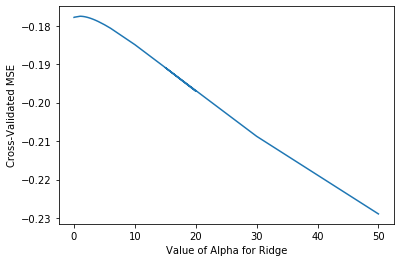

In [54]:
# plot the results
plt.plot(alpha_range, grid_mean_scores)
plt.xlabel('Value of Alpha for Ridge')
plt.ylabel('Cross-Validated MSE')

Text(0, 0.5, 'Cross-Validated MSE')

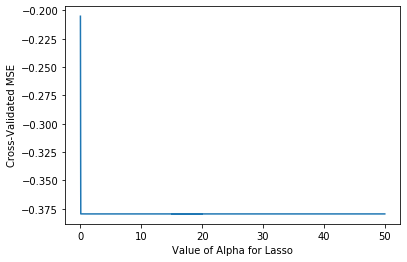

In [55]:
# plot the results
plt.plot(alpha_range, grid_mean_scores2)
plt.xlabel('Value of Alpha for Lasso')
plt.ylabel('Cross-Validated MSE')

In [56]:
# examine the best model
print(grid1.best_score_)
print(grid1.best_params_)
print(grid1.best_estimator_)

print(grid2.best_score_)
print(grid2.best_params_)
print(grid2.best_estimator_)



-0.17753280734153568
{'alpha': 1}
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
-0.20522428646418933
{'alpha': 0.01}
Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
